COCO Dataset to YOLO Format Conversion and Training with Ultralytics YOLOv8

In [ ]:
import os
import json
import shutil
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
import numpy as np

Configuration

In [ ]:
# Set the home directory
HOME = Path.cwd()

# Set paths
COCO_PATH = Path('/content/drive/MyDrive/coco2017')
OUTPUT_PATH = HOME / 'data'

# Choose your desired annotation type: 'bbox', 'keypoints', or 'segmentation'
chosen_annotation_type = 'segmentation'

# Data reduction factors (set to 1.0 to use the full dataset)
train_reduce_factor = 0.1
val_reduce_factor = 0.2

Helper Functions

In [ ]:
# Function to convert COCO bbox to YOLO format
def coco_to_yolo_bbox(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2] / 2) / img_width
    y_center = (bbox[1] + bbox[3] / 2) / img_height
    width = bbox[2] / img_width
    height = bbox[3] / img_height
    return [x_center, y_center, width, height]

# Function to convert COCO segmentation to YOLO format
def coco_to_yolo_seg(segmentation, img_width, img_height):
    poly = np.array(segmentation).flatten().tolist()
    return [coord / img_width if i % 2 == 0 else coord / img_height for i, coord in enumerate(poly)]

# Function to convert COCO keypoints to YOLO format
def coco_to_yolo_keypoints(keypoints, img_width, img_height):
    yolo_keypoints = []
    for i in range(0, len(keypoints), 3):
        x, y, v = keypoints[i:i+3]
        if v > 0:  # Only include visible keypoints
            yolo_keypoints.extend([x / img_width, y / img_height, v])
    # Pad with zeros if less than 17 keypoints
    while len(yolo_keypoints) < 51:  # 17 keypoints * 3 values = 51
        yolo_keypoints.extend([0, 0, 0])  # Add dummy keypoints
    return yolo_keypoints

# Function to process a single image
def process_image(img, annotations, cat_id_to_name, split, reduce_factor, valid_class_ids, annotation_type):
    if random.random() > reduce_factor:
        return

    img_id = img['id']
    img_name = img['file_name']
    img_width, img_height = img['width'], img['height']

    # Copy image
    src_img_path = COCO_PATH / f'{split}2017' / img_name
    dst_img_path = OUTPUT_PATH / split / 'images' / img_name
    shutil.copy(src_img_path, dst_img_path)

    # Process annotations for this image
    label_path = OUTPUT_PATH / split / 'labels' / (Path(img_name).stem + '.txt')
    with open(label_path, 'w') as label_file:
        for ann in annotations:
            if ann['image_id'] == img_id:
                cat_id = ann['category_id']
                if cat_id in valid_class_ids:
                    if annotation_type == 'bbox':
                        bbox = ann['bbox']
                        yolo_bbox = coco_to_yolo_bbox(bbox, img_width, img_height)
                        label_file.write(f"{valid_class_ids.index(cat_id)} {' '.join(map(str, yolo_bbox))}\n")
                    elif annotation_type == 'segmentation':
                        segmentation = ann['segmentation'][0] # Assuming single polygon
                        yolo_seg = coco_to_yolo_seg(segmentation, img_width, img_height)
                        label_file.write(f"{valid_class_ids.index(cat_id)} {' '.join(map(str, yolo_seg))}\n")
                    elif annotation_type == 'keypoints' and ann['category_id'] == 1: # Only for person
                        bbox = ann['bbox']
                        keypoints = ann['keypoints']
                        yolo_bbox = coco_to_yolo_bbox(bbox, img_width, img_height)
                        yolo_keypoints = coco_to_yolo_keypoints(keypoints, img_width, img_height)
                        label_file.write(f"0 {' '.join(map(str, yolo_bbox + yolo_keypoints))}\n")

# Function to process dataset
def process_dataset(split, reduce_factor=1.0, annotation_type='bbox'):
    print(f"Processing {split} dataset with annotation type: {annotation_type}...")

    # Load annotations
    if annotation_type == 'keypoints':
        annotation_file = f'person_keypoints_{split}2017.json'
    else:
        annotation_file = f'instances_{split}2017.json'

    with open(COCO_PATH / 'annotations' / annotation_file) as f:
        coco_data = json.load(f)

    # Create category id to name mapping
    global cat_id_to_name  # Declare cat_id_to_name as global
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Get valid class IDs (0-79)
    valid_class_ids = sorted(list(cat_id_to_name.keys()))[:80]

    # Create a dictionary of annotations by image_id for faster lookup
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)

    # Process images and annotations in parallel
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = []
        for img in coco_data['images']:
            future = executor.submit(process_image, img, annotations_by_image.get(img['id'], []),
                                     cat_id_to_name, split, reduce_factor, valid_class_ids, annotation_type)
            futures.append(future)

        for future in tqdm(as_completed(futures), total=len(futures)):
            pass  # We're just using tqdm to show progress

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preparation

In [ ]:
# Create output directories
for split in ['train', 'val']:
    for subdir in ['images', 'labels']:
        (OUTPUT_PATH / split / subdir).mkdir(parents=True, exist_ok=True)

# Process datasets
process_dataset('train', reduce_factor=train_reduce_factor, annotation_type=chosen_annotation_type)
process_dataset('val', reduce_factor=val_reduce_factor, annotation_type=chosen_annotation_type)

Processing train dataset with annotation type: segmentation...


100%|██████████| 118287/118287 [00:08<00:00, 14686.14it/s]


Processing val dataset with annotation type: segmentation...


100%|██████████| 5000/5000 [00:04<00:00, 1244.36it/s]


Create config.yaml

In [ ]:
# Create config.yaml based on the chosen annotation type
if chosen_annotation_type == 'keypoints':
    config = {
        'path': str(OUTPUT_PATH),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 1,
        'names': ['person'],
        'kpt_shape': [17, 3],
        'flip_idx': [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    }
else:
    config = {
        'path': str(OUTPUT_PATH),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 80,
        'names': [cat_id_to_name[id] for id in sorted(list(cat_id_to_name.keys()))[:80]]
    }
with open(OUTPUT_PATH / "config.yaml", 'w') as f:
    json.dump(config, f, indent=2)

print("Dataset preprocessing completed.")

Dataset preprocessing completed.


Install Ultralytics YOLOv8

In [ ]:
!pip install ultralytics
!pip uninstall -y wandb  # Optional: Uninstall wandb if not needed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 15.0 MB/s eta 0:00:00


Model Training

In [ ]:
from ultralytics import YOLO

# Choose the appropriate model based on the annotation type
if chosen_annotation_type == 'bbox':
    model = YOLO("yolov8n.pt")
    train_folder = 'detect'
elif chosen_annotation_type == 'segmentation':
    model = YOLO("yolov8n-seg.pt")
    train_folder = 'segment'
elif chosen_annotation_type == 'keypoints':
    model = YOLO("yolov8n-pose.pt")
    train_folder = 'pose'

# Train the model
results = model.train(data=f"{HOME}/data/config.yaml", epochs=10, imgsz=640)

100%|██████████| 6.74M/6.74M [00:00<00:00, 74.5MB/s]


Ultralytics YOLOv8.2.88 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data/config.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/data/train/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 353.95it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<00:00, 1141.57it/s]

val: New cache created: /content/data/val/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.228      2.693      1.465      1.215         94        640: 100%|██████████| 1/1 [00:29<00:00, 29.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:21<00:00, 21.32s/it]

                   all         24        170      0.474      0.662      0.639      0.459      0.465      0.671      0.636      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.301      2.996      1.755      1.311         84        640: 100%|██████████| 1/1 [00:22<00:00, 22.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.84s/it]

                   all         24        170      0.486      0.646      0.633       0.45      0.499      0.619      0.631      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.354      2.994      1.708      1.321         92        640: 100%|██████████| 1/1 [00:19<00:00, 19.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.58s/it]

                   all         24        170      0.501      0.653      0.639      0.449      0.504      0.653      0.629      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.297      2.894      1.738      1.295         89        640: 100%|██████████| 1/1 [00:20<00:00, 20.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.04s/it]

                   all         24        170      0.503      0.662      0.642      0.453        0.5      0.655      0.628      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.286      2.829      1.479      1.239         98        640: 100%|██████████| 1/1 [00:19<00:00, 19.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.14s/it]

                   all         24        170      0.499      0.667      0.641      0.453      0.499      0.658      0.627      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.116      2.693      1.535      1.191         95        640: 100%|██████████| 1/1 [00:21<00:00, 21.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.63s/it]

                   all         24        170      0.497      0.668      0.645      0.455      0.499       0.66      0.627      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G       1.21      2.719      1.521      1.177         95        640: 100%|██████████| 1/1 [00:19<00:00, 19.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.27s/it]

                   all         24        170      0.496      0.671      0.646      0.455      0.496      0.667      0.634      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.147       2.76      1.467      1.122         96        640: 100%|██████████| 1/1 [00:18<00:00, 18.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.54s/it]

                   all         24        170      0.492      0.671      0.643      0.455      0.491      0.659      0.626      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.151      2.511      1.363      1.232         91        640: 100%|██████████| 1/1 [00:19<00:00, 19.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.61s/it]

                   all         24        170      0.491      0.671      0.642      0.451      0.492      0.664      0.631      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.129      2.694      1.408       1.15         98        640: 100%|██████████| 1/1 [00:18<00:00, 18.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]

                   all         24        170       0.49      0.668      0.641      0.451      0.499      0.654      0.633      0.407



10 epochs completed in 0.111 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 7.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 7.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.88 🚀 Python-3.10.12 torch-2.4.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.74s/it]


                   all         24        170      0.474      0.662      0.639      0.459      0.465      0.671      0.636      0.422
                person         14         70      0.658      0.514      0.511      0.299      0.531      0.429      0.428      0.225
                   car          4          7      0.325      0.714      0.611      0.429      0.318      0.714      0.611      0.342
            motorcycle          3          3          1      0.665      0.995      0.736          1      0.667      0.995      0.636
              airplane          1          2      0.337        0.5      0.745      0.463      0.669          1      0.995      0.573
                   bus          1          1      0.352          1      0.497      0.497      0.351          1      0.497      0.497
                 train          1          1      0.379          1      0.995      0.995      0.376          1      0.995      0.895
                 truck          2          5     0.0947        0.2   

Visualize Training Results

Displaying training results for segmentation...
args.yaml					   labels_correlogram.jpg  train_batch0.jpg
BoxF1_curve.png					   labels.jpg		   train_batch1.jpg
BoxP_curve.png					   MaskF1_curve.png	   train_batch2.jpg
BoxPR_curve.png					   MaskP_curve.png	   val_batch0_labels.jpg
BoxR_curve.png					   MaskPR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			   MaskR_curve.png	   weights
confusion_matrix.png				   results.csv
events.out.tfevents.1725600144.bbae19c4b814.686.0  results.png


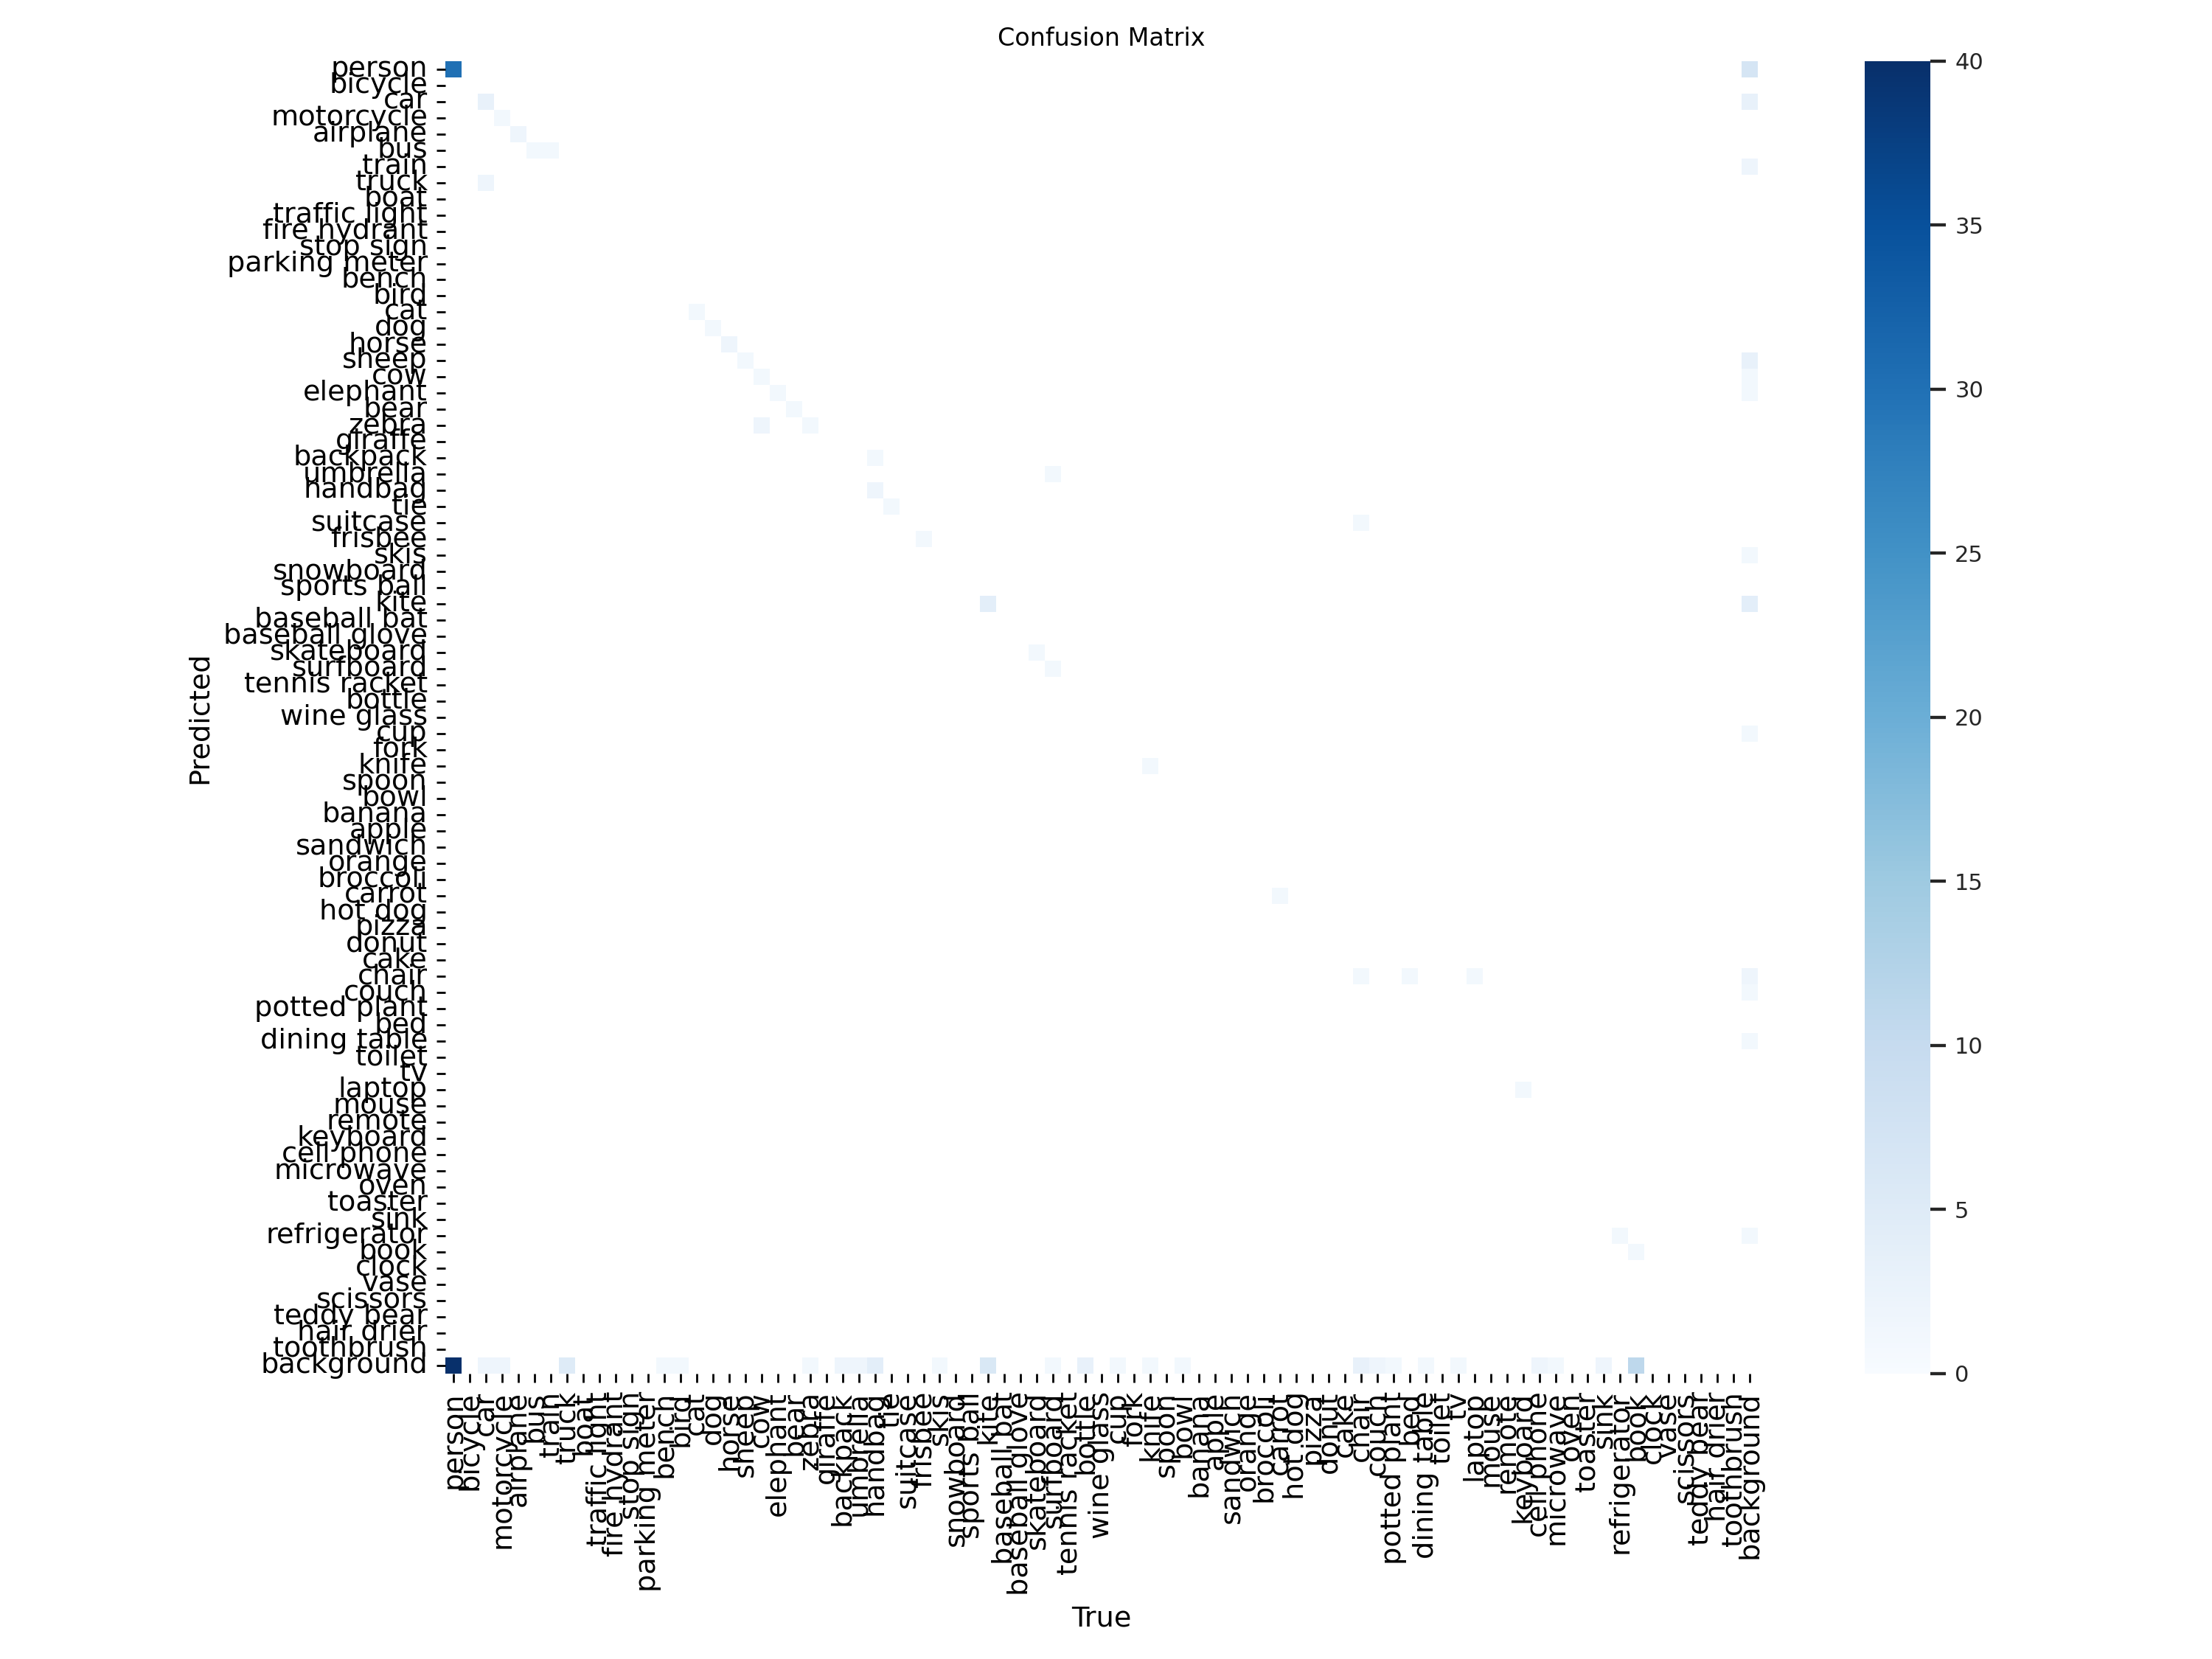

In [ ]:
from IPython.display import Image

# Display training results automatically
print(f"Displaying training results for {chosen_annotation_type}...")

!ls {HOME}/runs/{train_folder}/train

Image(filename=f'{HOME}/runs/{train_folder}/train/confusion_matrix.png', width=600)

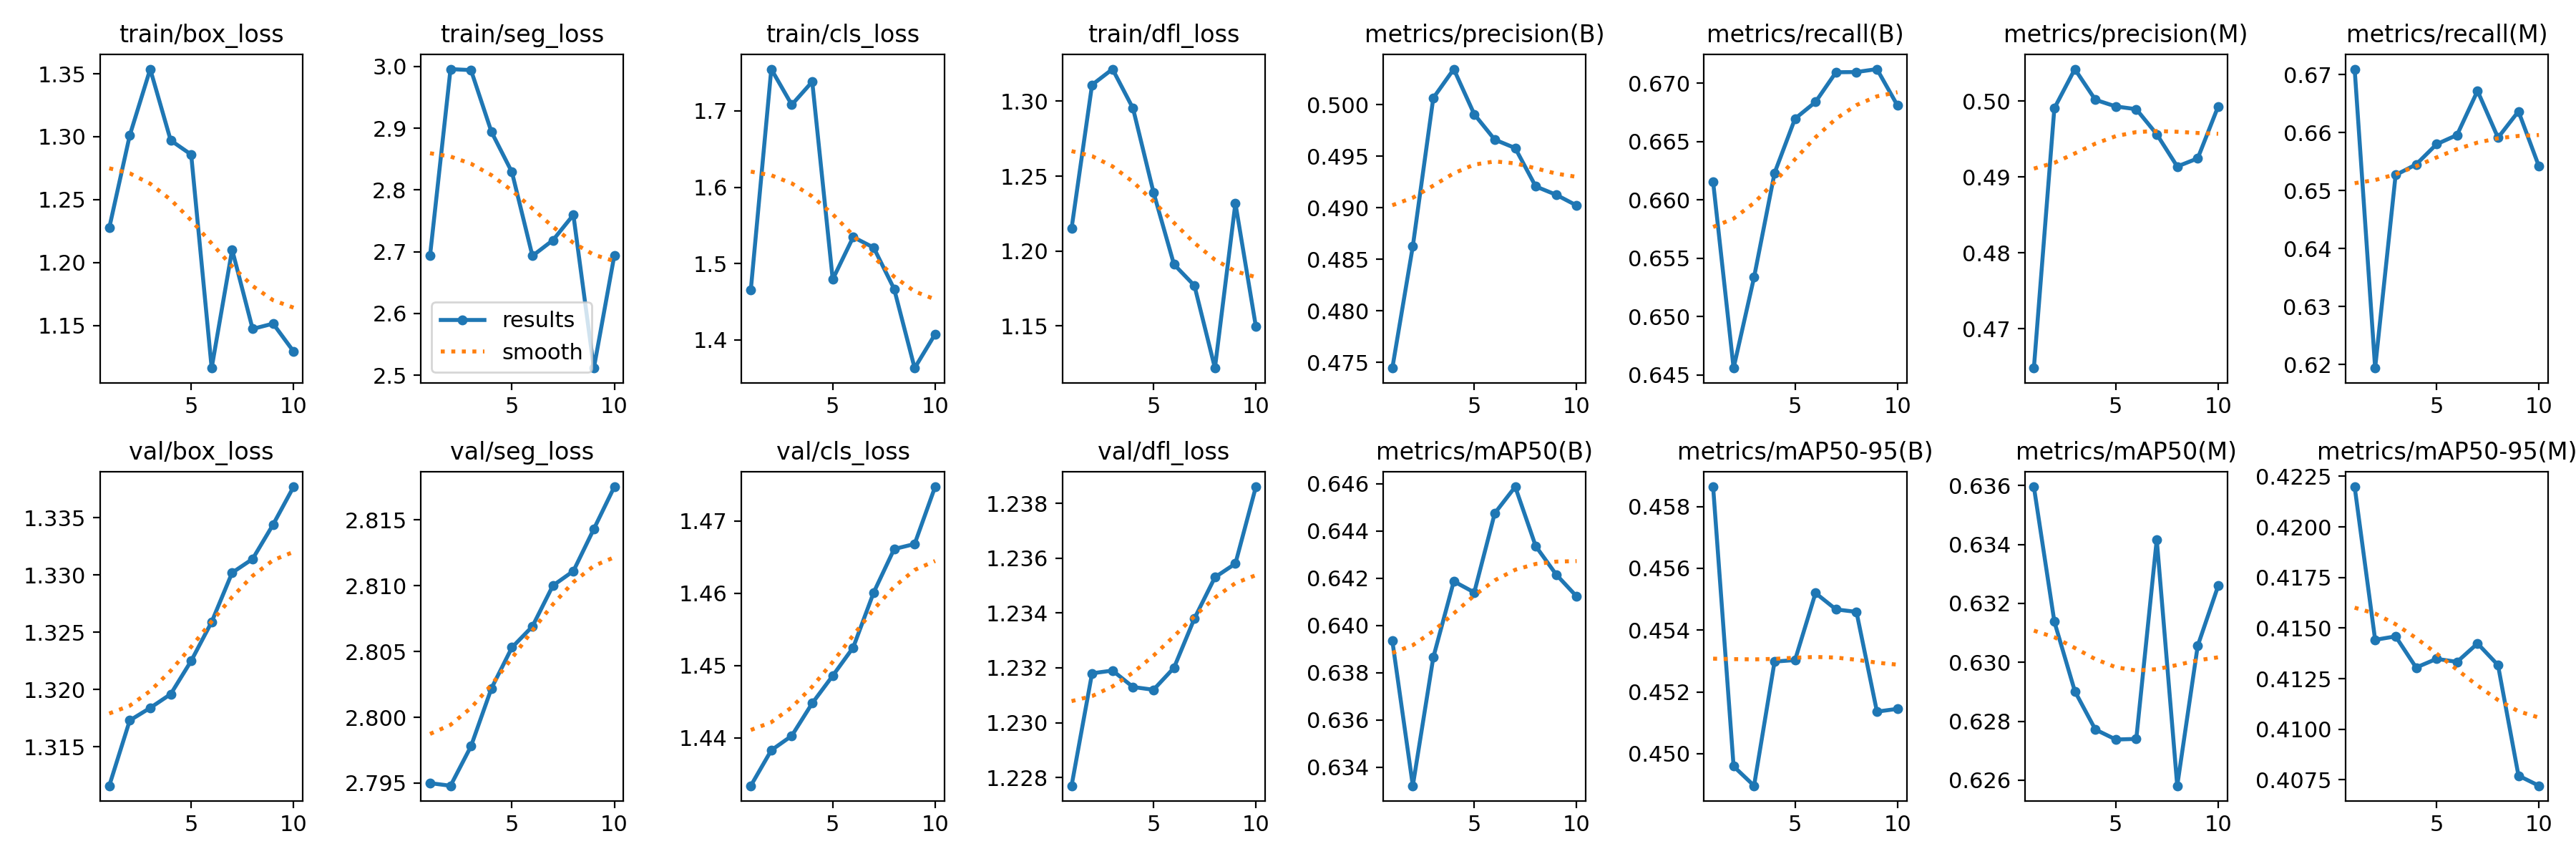

In [ ]:
Image(filename=f'{HOME}/runs/{train_folder}/train/results.png', width=600)

Model Prediction

In [ ]:
# Load a model
model = YOLO(f'{HOME}/runs/{train_folder}/train/weights/best.pt')  # load a custom model




image 1/1 /content/drive/MyDrive/coco2017/test2017/000000000108.jpg: 224x320 1 train, 108.3ms
Speed: 1.5ms preprocess, 108.3ms inference, 12.3ms postprocess per image at shape (1, 3, 224, 320)
Results saved to runs/segment/predict


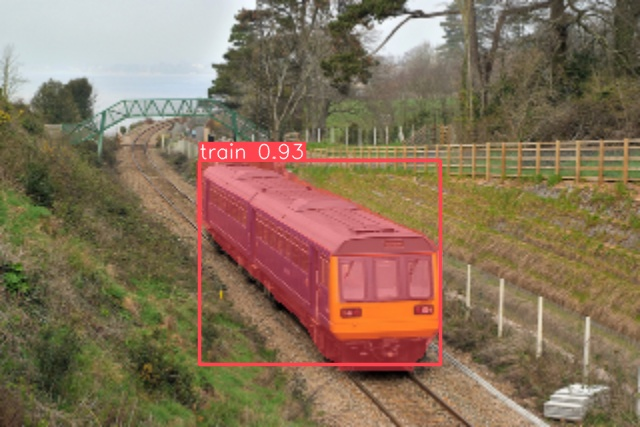

In [ ]:
# Predict with the model
results = model(f'{COCO_PATH}/test2017/000000000108.jpg', save=True, imgsz=320, conf=0.5)
 # predict on an image

# Display the prediction image
Image(filename=f'runs/{train_folder}/predict/000000000108.jpg', height=600)

# Display the prediction image
Image(filename=f'runs/{train_folder}/predict/000000000108.jpg', height=600)


image 1/1 /content/drive/MyDrive/coco2017/test2017/000000000662.jpg: 224x320 1 airplane, 147.8ms
Speed: 1.4ms preprocess, 147.8ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 320)
Results saved to runs/segment/predict2


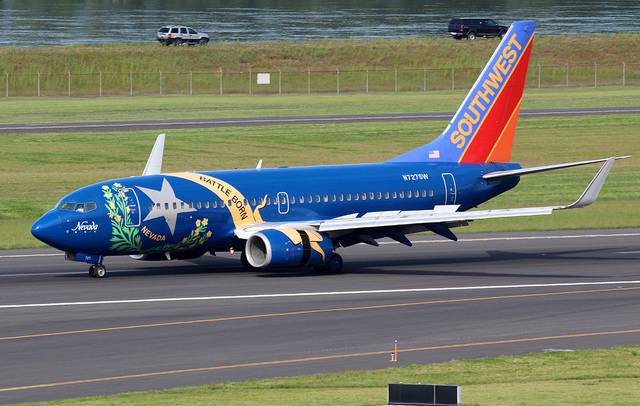

In [ ]:
# Load a model
model = YOLO(f'{HOME}/runs/{train_folder}/train/weights/best.pt')  # load a custom model

# Predict with the model
results = model(f'{COCO_PATH}/test2017/000000000662.jpg', save=True, imgsz=320, conf=0.5)  # predict on an image

# Display the prediction image
Image(filename=f'runs/{train_folder}/predict/000000000662.jpg', height=600)